In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Part (b), investigation of reconstruction error with analytically obtained l2-norm minimizer, and we know the optimal solution from the solution of homework3

$$
f(\mathbf{x})=\|\mathbf{A} \mathbf{x}-\mathbf{y}\|_2^2+\lambda\|\mathbf{x}\|_2^2,
$$
$$
\nabla f(\mathbf{x})=2\left(\mathbf{A}^T(\mathbf{A x}-\mathbf{y})+\lambda \mathbf{x}\right)
$$
$$
\nabla f(\mathbf{x})=\mathbf{0} \Leftrightarrow\left(\mathbf{A}^T \mathbf{A}+\lambda \mathbf{I}\right) \mathbf{x}=\mathbf{A}^T \mathbf{y} .
$$
$$
\begin{aligned}
\left(\mathbf{A}^T \mathbf{A}-\lambda \mathbf{I}\right) & =\mathbf{V} \boldsymbol{\Sigma}^2 \mathbf{V}^T+\lambda \mathbf{I}, \\
& \stackrel{*}{=} \mathbf{V} \boldsymbol{\Sigma}^2 \mathbf{V}^T+\lambda \mathbf{V} \mathbf{V}^T, \\
& =\mathbf{V}\left(\boldsymbol{\Sigma}^2+\lambda \mathbf{I}\right) \mathbf{V}^T,
\end{aligned}
$$
$$
\nabla f(\mathbf{x})=\mathbf{0} \Leftrightarrow\left(\mathbf{V}\left(\boldsymbol{\Sigma}^2+\lambda \mathbf{I}\right) \mathbf{V}^T\right) \mathbf{x}=\mathbf{A}^T \mathbf{y}
$$
$$
\begin{aligned}
\left(\mathbf{V}\left(\boldsymbol{\Sigma}^2+\lambda \mathbf{I}\right) \mathbf{V}^T\right) \mathbf{x}=\mathbf{A}^T \mathbf{y} & \Leftrightarrow\left(\mathbf{V}\left(\boldsymbol{\Sigma}^2+\lambda \mathbf{I}\right) \mathbf{V}^T\right) \mathbf{x}=\mathbf{V} \boldsymbol{\Sigma} \mathbf{U}^T \mathbf{y} \\
& \Leftrightarrow \mathbf{x}=\mathbf{V}\left(\boldsymbol{\Sigma}^2+\lambda \mathbf{I}\right)^{-1} \boldsymbol{\Sigma} \mathbf{U}^T \mathbf{y},
\end{aligned}
$$
Note that:
$$
\left(\boldsymbol{\Sigma}^2+\lambda \mathbf{I}\right)^{-1} \boldsymbol{\Sigma}=\operatorname{diag}\left(\frac{\sigma_1}{\sigma_1^2+\lambda}, \ldots, \frac{\sigma_n}{\sigma_n^2+\lambda}\right)
$$

In [2]:
# Creation of random matrix A(500by2000) whose entries are drawn iid from N(0,1/500)
var_A = 1/500
mean_A = 0
A = np.sqrt(var_A)*np.random.randn(500,2000) + mean_A
U,S,Vh= np.linalg.svd(A, full_matrices=False)
diagS = np.diag(S)

In [3]:
# Creation of 50-sparse vector x drawn from
var_x = 1/50
mean_x = 0
x = np.sqrt(var_x)*np.random.randn(2000) + mean_x
zero_indices = np.random.choice(np.arange(2000),replace=False,size=int(1950)) #1950 random indices
x[zero_indices]=0 #x is 50-sparse
x=np.reshape(x,(2000,1))

In [4]:
# random noise vector
var_e = 0.5/500
mean_e = 0
e = np.sqrt(var_e)*np.random.randn(500,1)+mean_e

In [5]:
lamda_max = 5
lamda_list = np.linspace(0,lamda_max,num=200)
y = A@x +e

In [6]:
mse_list = []
for lamda in tqdm(lamda_list):
    sigma_fac = np.diag([S[num]/(S[num]**2+lamda) for num in range(len(S))])
    x2_opt = (Vh.T@(sigma_fac@(U.T@y))) #multiplying vectors with matrices are faster than multiplying matrices
    mse_list.append(np.linalg.norm(x2_opt-x)**2)


 22%|██▏       | 44/200 [00:00<00:00, 430.52it/s]

100%|██████████| 200/200 [00:00<00:00, 374.18it/s]


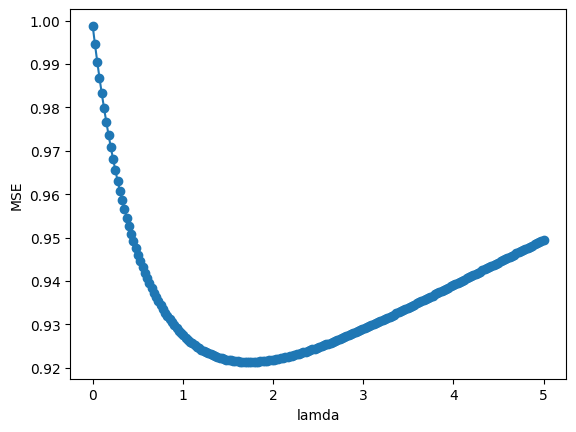

In [7]:
plt.xlabel('lamda')
plt.ylabel('MSE')
plt.plot(lamda_list,mse_list,marker="o")

### Part (C), investigation of reconstruction error with l1-norm, here we don't have a closed-form expression because the l1-norm minimization is not a convex problem. Therefore, we need to use ISTA algorithm to approximate the estimate.

In [8]:
temp_mse=[]
max_iterations=100
alpha=0.0001 #step size

#derivative of function f
def delta_f(x):
    return A.T@(A@x-y)

#Soft Thresholding Operator
def STO(x,lamda,alpha):
    c=lamda*alpha
    x[(x>=-c)&(x<=c)]=0
    x[x<-c]+=c
    x[x>c]-=c
    return x

for lamda in tqdm(lamda_list):
    x_k=np.zeros((2000,1)) #initialize x: x_0=0
    #ISTA
    for _ in range(max_iterations):
        x_k-=alpha*delta_f(x_k) #step update for f(x)
        x_k=STO(x_k,lamda,alpha) #soft thresholding
    x1_opt = x_k
    temp_mse.append(np.linalg.norm(x1_opt-x)**2)

100%|██████████| 200/200 [00:23<00:00,  8.68it/s]


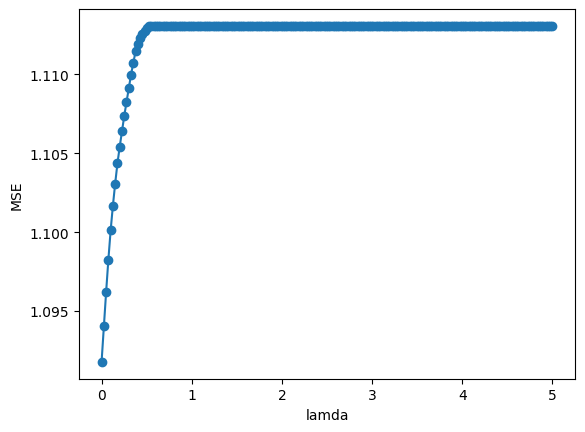

In [9]:
plt.xlabel('lamda')
plt.ylabel('MSE')
plt.plot(lamda_list,temp_mse,marker="o")